In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
from utils import load_airlines_series

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 4)

This notebook is for the extra curious ones and intends to address the issue of calculating lagged correlations in timeseries with missing data.

The aim here is for you to understand the problem at hand and propose a solution. However, this notebook does not provide you the tools to reproduce the exact same plots as the ones shown in the learning notebook (in terms of aesthetics and the information on uncertainty).

<img src="media/curious_jack.jpg">

In [2]:
# Loading same data as in the Learning Notebook Part 2
airlines = utils.load_airline_data()
airlines_logged = np.log(airlines)

train = airlines_logged[:-24]

When you calculate the `diff()` of train, the first value is `nan` (since there is no value for 1948-12-01 to subtract it with)

In [3]:
train.diff().head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Freq: MS, Name: passengers_thousands, dtype: float64

We get a similar behaviour when applying `.shift()` (more info on this [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html))

In [4]:
train.shift(2).head()

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01    4.718499
1949-04-01    4.770685
1949-05-01    4.882802
Freq: MS, Name: passengers_thousands, dtype: float64

In [5]:
train.shift(-3).tail()

Month
1958-08-01    5.736572
1958-09-01    5.820083
1958-10-01         NaN
1958-11-01         NaN
1958-12-01         NaN
Freq: MS, Name: passengers_thousands, dtype: float64

Correlation calculations can't handle `nan` values and in the Learning Notebook we handled this with a `dropna()`. But why did we stress that **this is okay only  when the `nan` values are in the beginning or end of the timeseries**?

Because these calculations do not look at timestamps and assume that the time interval between consecutive values is always the same.

In [6]:
# Meaning that if the data from April to July 1949 were missing
train2 = train.copy()
train2[3:7] = np.nan

# If you calculate the ACR after doing a `.dropna()`, it will assume that the 3rd row is the 1st lagged term (1 month before)
# of the 4th row, when in fact it is 5 months.
train.dropna().head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Freq: MS, Name: passengers_thousands, dtype: float64

This make the **temporal meaning of a lag inconsistent throughout the timeseries** (i.e. whenever there's a "data hole" the actual lag between two consecutive data points will be >1).

Now, a suggestion on how to handle this:
- create an explicit lagged column (using `.shift()`),
- delete the rows where either the original or the lagged timeseries are `nan`
- calculate the correlation between the two (which traditionally is called a cross-correlation)

That way you effectively drop the `nan` values, but keep the correct original-lag term correspondence. The fact that we did the lag before dropping the `nan` ensures this.

Find below a function aiming to do this.

In [7]:
# Function receiving the pd.Series x and the maximum lag to be considered (default = 25)
# Flow:
# 1) a dataframe df is created containing x and its lagged terms (calculated using the .shift() from pandas)
# 2) For each lag, the original timeseries and the lagged term are put side by side in df2
# 3) Rows with nan values are dropped
# 4) The autocorrelation is calculated using the corrcoef function from numpy

# Although this function is actually meant for cross-correlations (correlation between a pair of variables),
# it can be adapted by providing one variable two times as input (one of them lagged)

def autocorrelation(x, max_lag = 25):
    # to store the obtained acf values
    acf_values = np.array([])
    
    # convert pd.Series to pd.DataFrame
    df = pd.DataFrame(x)

    # creates the lagged terms of x
    for lag in range(0,max_lag):
        # naming the columns
        if lag<10:
            col_name = 'lag_0' + str(lag)
        else:
            col_name = 'lag_' + str(lag)

        df[col_name] = x.shift(-lag)
    
    # calculates the acf values
    for lag in range(0,max_lag):
        if lag<10:
            col_name = 'lag_0' + str(lag)
        else:
            col_name = 'lag_' + str(lag)
        
        # stores the two columns of interest (the original timeseries and the lagged term under evaluation)
        # drops rows with nan
        df2 = df[[df.columns[0],col_name]].dropna()
        
        # calculates acf for a given lag
        val = np.corrcoef(df2.iloc[:,0],df2.iloc[:,1])[0,1]
        
        # stores calculated acf value
        acf_values = np.append(acf_values,val)
    
    return acf_values

### Example 1: showing that `nan` in the beginning/end of the timeseries have no impact in the ACF

In [8]:
# ACF of the diffed train (with 1 nan in the beginning) letting the function handle the nan values
acf_values_1 = autocorrelation(x = train.diff())

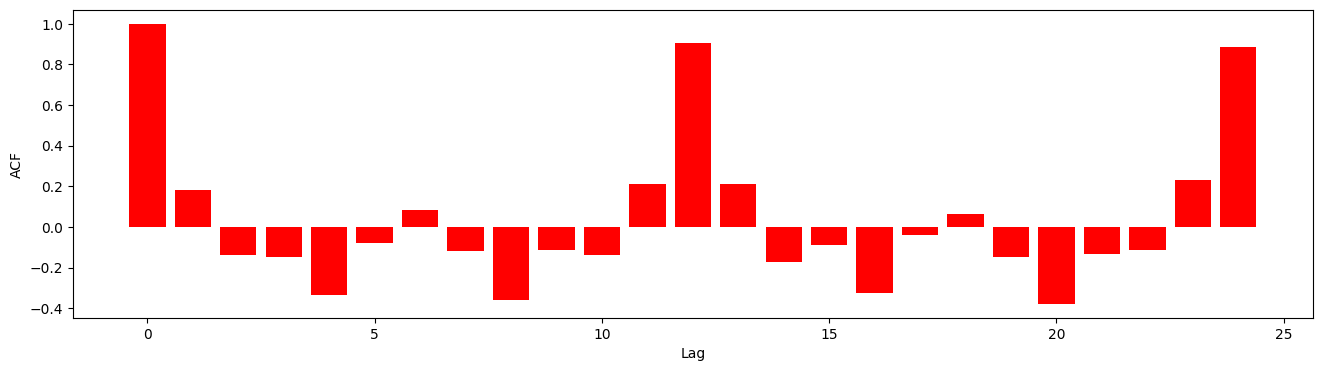

In [9]:
plt.bar(x=list(range(0,len(acf_values_1))),height=acf_values_1, color = 'red', width=0.8)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [10]:
# ACF of the same series, but handling the nan values with dropna in the raw diffed timeseries
acf_values_2 = autocorrelation(x = train.diff().dropna())

In [11]:
# difference between ACF values. as you can see, no difference whatsoever
acf_values_1 - acf_values_2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

### Example 2: showing that `nan` in the middle of the timeseries impact the ACF

In [12]:
train2 = train.copy()
train2.iloc[[2,16,30,76,118]] = np.nan

In [13]:
# ACF of the diffed train (now also with a few nan in the middle) letting the function handle the nan values
acf_values_3 = autocorrelation(x = train2.diff())

In [14]:
# ACF of the same series, but handling the nan values with dropna in the raw diffed timeseries
acf_values_4 = autocorrelation(x = train2.diff().dropna())

In [15]:
display(acf_values_3 - acf_values_4)

display([np.min(acf_values_3 - acf_values_4), np.max(acf_values_3 - acf_values_4)])

array([ 0.        ,  0.01347961, -0.03031757, -0.01911206,  0.01444697,
        0.01274504,  0.1099722 ,  0.00183928, -0.12275707, -0.06985759,
       -0.32298508, -0.01808211,  0.40271841,  0.10198756,  0.05393898,
       -0.0327418 , -0.16911426,  0.0773975 ,  0.17460509, -0.04961625,
       -0.21825526, -0.18075299, -0.36730495,  0.08438211,  0.5801035 ])

[-0.36730494854868995, 0.580103504995535]

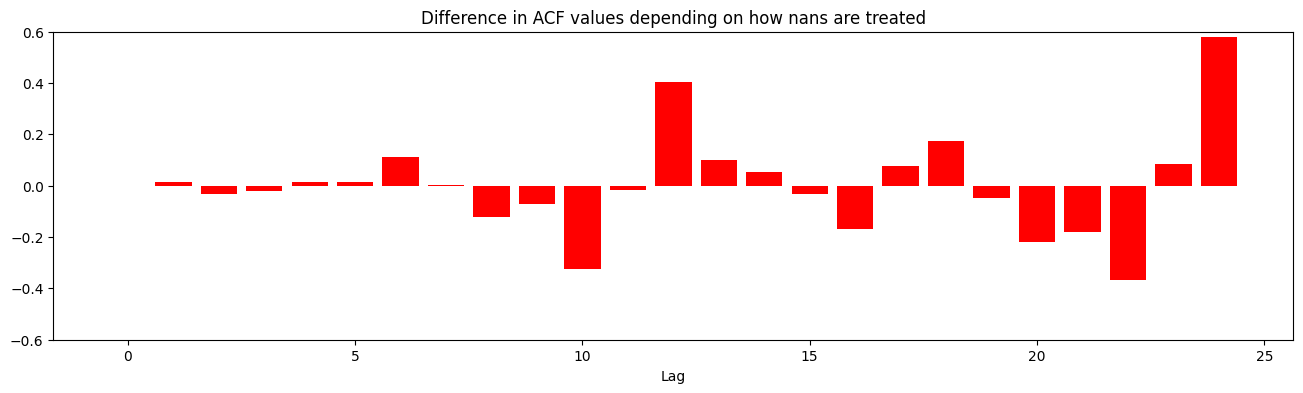

In [16]:
plt.bar(x=list(range(0,len(acf_values_3))),height=acf_values_3-acf_values_4, color = 'red', width=0.8)
plt.xlabel('Lag')
plt.title('Difference in ACF values depending on how nans are treated')
plt.ylim([-0.6,0.6])
plt.show()

<img src="media/looney.png">

We know this was a bit too specific, but again... take it as a supplementary knowledge.
Maybe for future reference, who knows :)